# Importing libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
df = yf.download('AAPL', start='2010-01-01')
df.columns = df.columns.droplevel(1) 
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,6.440332,6.455078,6.391280,6.422878,493729600
2010-01-05,6.451466,6.487879,6.417460,6.458087,601904800
2010-01-06,6.348846,6.477045,6.342225,6.451465,552160000
2010-01-07,6.337110,6.379844,6.291067,6.372320,477131200
2010-01-08,6.379241,6.379844,6.291369,6.328684,447610800


Price,Close,High,Low,Open,Volume
count,3819.000000,3819.000000,3819.000000,3819.000000,3.819000e+03
mean,69.509170,70.188330,68.757924,69.452890,2.278325e+08
std,67.712103,68.356367,66.977606,67.636817,2.176325e+08
min,5.779476,5.898344,5.725306,5.789105,2.323470e+07
25%,17.605746,17.743939,17.417068,17.601060,8.372580e+07
50%,35.915863,36.128096,35.689850,35.918194,1.380234e+08
75%,129.654259,131.337215,128.307567,129.689002,3.051174e+08
max,258.735504,259.814335,257.347047,257.906429,1.880998e+09


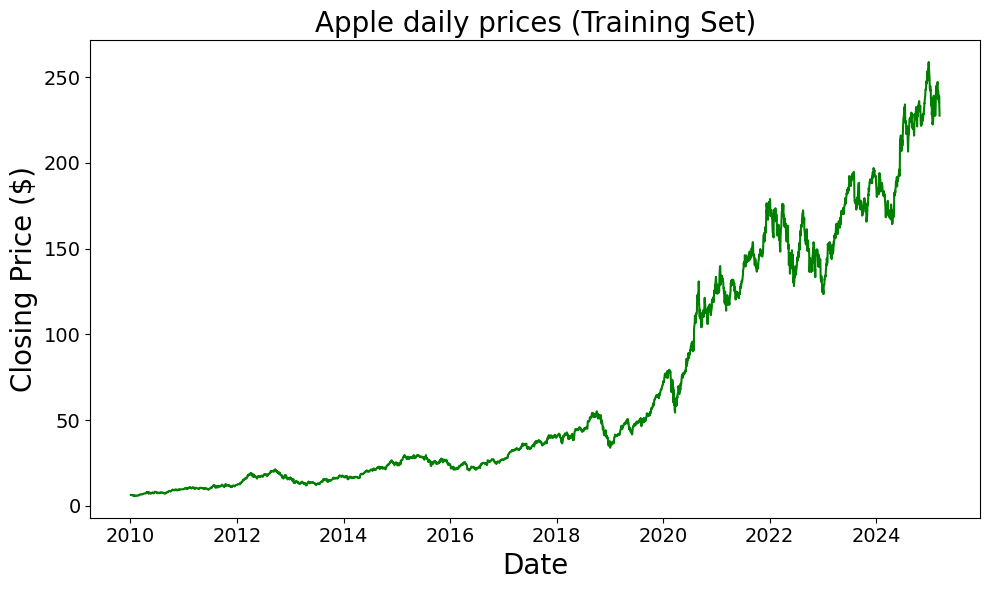

In [3]:
plt.figure(figsize=(10,6))
plt.plot(
  df.index,
  df['Close'],
  #label="Close Price ($)",
  color="green"
)
#plt.legend(fontsize=18, loc="upper left")
plt.yticks(fontsize=14)
plt.xlabel("Date", fontsize=20)
plt.xticks(fontsize=14)
plt.ylabel("Closing Price ($)", fontsize=20)
plt.title("Apple daily prices (Training Set)", fontsize=20)
plt.tight_layout()
df.describe()

# Scaling

In [4]:
X, y = df.drop(columns=['Close']), df['Close'].values

mm = MinMaxScaler()
ss = StandardScaler()
X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))    # Scaling is crucial for NNs

## Preparing data

In [5]:
def split_sequences(input_sequences, output_sequences, n_steps_in, n_steps_out):
    X, y = list(), list() #Instantiate X and y
    for i in range(len(input_sequences)):
        # Find the end of the input, output sequence
        end_idx = i + n_steps_in
        out_end_idx = end_idx + n_steps_out - 1

        # Check if we are beyond the dataset
        if out_end_idx > len(input_sequences):
            break
        # Gather input and output of the pattern
        seq_x = input_sequences[i:end_idx]
        seq_y = output_sequences[end_idx-1:out_end_idx, - 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50) # Let's try to predict 50 days based on 100
print(X_ss.shape, y_mm.shape)

(3671, 100, 4) (3671, 50)


Let's check that the first sample in `y_mm` indeed starts at the 100th sample in the original target `y` vector.

In [6]:
y_mm[0]

array([0.00619346, 0.00729272, 0.00771268, 0.0081826 , 0.00855378,
       0.00845503, 0.00760322, 0.00700602, 0.00681448, 0.0060852 ,
       0.00695485, 0.00731176, 0.00740335, 0.00804698, 0.00894637,
       0.00949601, 0.00975773, 0.00929375, 0.00973155, 0.00938893,
       0.00915457, 0.00888094, 0.00907129, 0.00762821, 0.0070762 ,
       0.00671335, 0.00653014, 0.00673119, 0.00792563, 0.00785663,
       0.00803864, 0.00776145, 0.00710832, 0.00721894, 0.00706668,
       0.00688227, 0.00636834, 0.00711903, 0.0073986 , 0.00796727,
       0.00807672, 0.0079982 , 0.00856923, 0.00819806, 0.00785902,
       0.00775669, 0.00830395, 0.00831346, 0.00843839, 0.0082861 ])

In [7]:
y_trans[99:149].squeeze(1)

array([0.00619346, 0.00729272, 0.00771268, 0.0081826 , 0.00855378,
       0.00845503, 0.00760322, 0.00700602, 0.00681448, 0.0060852 ,
       0.00695485, 0.00731176, 0.00740335, 0.00804698, 0.00894637,
       0.00949601, 0.00975773, 0.00929375, 0.00973155, 0.00938893,
       0.00915457, 0.00888094, 0.00907129, 0.00762821, 0.0070762 ,
       0.00671335, 0.00653014, 0.00673119, 0.00792563, 0.00785663,
       0.00803864, 0.00776145, 0.00710832, 0.00721894, 0.00706668,
       0.00688227, 0.00636834, 0.00711903, 0.0073986 , 0.00796727,
       0.00807672, 0.0079982 , 0.00856923, 0.00819806, 0.00785902,
       0.00775669, 0.00830395, 0.00831346, 0.00843839, 0.0082861 ])

In [8]:
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()

## Train/Test split

We want to predict the data several months into the future. Thus, we'll use a training data size of 95% , with 5% left for the data we want to predict.

In [9]:
total_samples = len(X_ss)
train_test_cutoff = round(total_samples * 0.95) # TODO: Check if correct

X_train, X_test = X_ss[:train_test_cutoff], X_ss[train_test_cutoff:]
y_train, y_test = y_mm[:train_test_cutoff], y_mm[train_test_cutoff:]
print("The meaning of each dimension in order: batch size, sequence length, number of features (input size)")
print(f"Training shape: {X_train.shape}, {y_train.shape}")
print(f"Testing shape: {X_test.shape}, {y_test.shape}")
print(f"Total samples: {total_samples}\nCutoff idx: {train_test_cutoff}")    

The meaning of each dimension in order: batch size, sequence length, number of features (input size)
Training shape: (3487, 100, 4), (3487, 50)
Testing shape: (184, 100, 4), (184, 50)
Total samples: 3671
Cutoff idx: 3487


## Converting to tensors

In [10]:
X_train_tensors = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensors = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train_tensors = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensors = torch.tensor(y_test, dtype=torch.float32).to(device)


print(X_train_tensors.shape, y_train_tensors.shape)
print(X_test_tensors.shape, y_test_tensors.shape)

torch.Size([3487, 100, 4]) torch.Size([3487, 50])
torch.Size([184, 100, 4]) torch.Size([184, 50])


Check if the 50 values we will be predicting match the last 50 values of `y` in the test set

In [11]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]

array([[2.12784842e+02, 1.95343462e+02, 1.98423107e+02, 1.19548600e+08],
       [2.09286623e+02, 2.00396503e+02, 2.04612330e+02, 6.96605000e+07],
       [2.12924384e+02, 2.05698669e+02, 2.06206955e+02, 6.35164000e+07],
       [2.13482492e+02, 2.08130485e+02, 2.12396147e+02, 4.71611000e+07]])

In [12]:
X.iloc[-149:-145]

Price,High,Low,Open,Volume
Date,,,,
2024-08-05,212.784842,195.343462,198.423107,119548600
2024-08-06,209.286623,200.396503,204.612330,69660500
2024-08-07,212.924384,205.698669,206.206955,63516400
2024-08-08,213.482492,208.130485,212.396147,47161100


In [13]:
y_check[-1]

array([257.91644287, 258.73550415, 255.30929565, 251.92301941,
       250.14497375, 243.5821991 , 243.09272766, 244.73092651,
       241.94400024, 242.43344116, 236.58987427, 234.14256287,
       233.02378845, 237.60874939, 228.00930786, 229.72741699,
       222.39547729, 223.58416748, 223.41436768, 222.5353241 ,
       229.60754395, 237.99832153, 239.09712219, 237.32905579,
       235.74081421, 227.75958252, 232.54432678, 232.21469116,
       232.96386719, 227.38000488, 227.6499939 , 232.61999512,
       236.86999512, 241.52999878, 244.6000061 , 244.47000122,
       244.86999512, 245.83000183, 245.55000305, 247.1000061 ,
       247.03999329, 240.36000061, 237.30000305, 241.83999634,
       238.02999878, 235.92999268, 235.74000549, 235.33000183,
       239.07000732, 227.47999573])

In [14]:
df['Close'].values[-50:]

array([257.91644287, 258.73550415, 255.30929565, 251.92301941,
       250.14497375, 243.5821991 , 243.09272766, 244.73092651,
       241.94400024, 242.43344116, 236.58987427, 234.14256287,
       233.02378845, 237.60874939, 228.00930786, 229.72741699,
       222.39547729, 223.58416748, 223.41436768, 222.5353241 ,
       229.60754395, 237.99832153, 239.09712219, 237.32905579,
       235.74081421, 227.75958252, 232.54432678, 232.21469116,
       232.96386719, 227.38000488, 227.6499939 , 232.61999512,
       236.86999512, 241.52999878, 244.6000061 , 244.47000122,
       244.86999512, 245.83000183, 245.55000305, 247.1000061 ,
       247.03999329, 240.36000061, 237.30000305, 241.83999634,
       238.02999878, 235.92999268, 235.74000549, 235.33000183,
       239.07000732, 227.47999573])

## Building the LSTM model

In [15]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 = nn.Linear(hidden_size,128) # fully connected
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # Input, hidden and internal state
        hn = hn.view(-1, self.hidden_size) # Reshaping data for dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

## Training the model

In [16]:
def training_loop(n_epochs, lstm, optimizer, loss_fn, X_train, y_train, X_test, y_test):
    for epoch in range(0, n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # Forward pass
        optimizer.zero_grad() # Calculate the gradient, manually setting to 0
        # Obtain loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # Calculates the loss of the loss function
        optimizer.step() # Improve from loss, i.e backprop
        # Test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Train Loss: {round(loss.item(),5)}, Test Loss: {round(test_loss.item(),5)}")

In [17]:
n_epochs = 3000
learning_rate = 0.001

input_size = 4 # Nr of features
hidden_size = 2 # Nr of features in hidden state
num_layers = 1 # Nr of stacked LSTM layers

num_classes = 50 # Nr of output classes

lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

/home/martin/projects/Geometric_DataAnalysis/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [18]:
training_loop(n_epochs=n_epochs, 
              lstm=lstm, 
              optimizer=optimizer, 
              loss_fn=loss_fn, 
              X_train=X_train_tensors, 
              y_train=y_train_tensors, 
              X_test=X_test_tensors, 
              y_test=y_test_tensors)

Epoch: 0, Train Loss: 0.13471, Test Loss: 0.74633
Epoch: 100, Train Loss: 0.00451, Test Loss: 0.10083
Epoch: 200, Train Loss: 0.00152, Test Loss: 0.05262
Epoch: 300, Train Loss: 0.00076, Test Loss: 0.01905
Epoch: 400, Train Loss: 0.00067, Test Loss: 0.01839
Epoch: 500, Train Loss: 0.00064, Test Loss: 0.0203
Epoch: 600, Train Loss: 0.00062, Test Loss: 0.02344
Epoch: 700, Train Loss: 0.00062, Test Loss: 0.02484
Epoch: 800, Train Loss: 0.00061, Test Loss: 0.02556
Epoch: 900, Train Loss: 0.00061, Test Loss: 0.02606
Epoch: 1000, Train Loss: 0.00061, Test Loss: 0.02643
Epoch: 1100, Train Loss: 0.00061, Test Loss: 0.02645
Epoch: 1200, Train Loss: 0.0006, Test Loss: 0.02652
Epoch: 1300, Train Loss: 0.0006, Test Loss: 0.02615
Epoch: 1400, Train Loss: 0.0006, Test Loss: 0.02573
Epoch: 1500, Train Loss: 0.0006, Test Loss: 0.02536
Epoch: 1600, Train Loss: 0.00059, Test Loss: 0.0234
Epoch: 1700, Train Loss: 0.00058, Test Loss: 0.02415
Epoch: 1800, Train Loss: 0.00058, Test Loss: 0.02487
Epoch: 1900

## Prediction

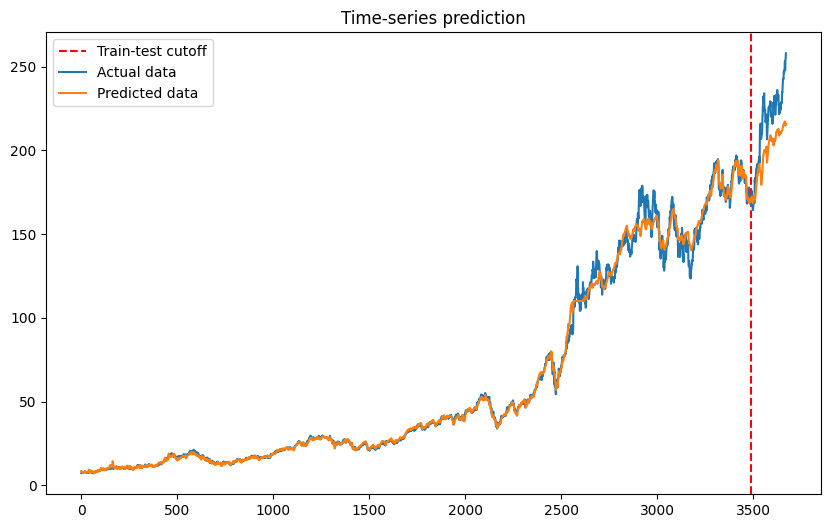

In [19]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # Old transformers
df_y_mm = mm.transform(df['Close'].values.reshape(-1, 1)) # Reshape because scikit-scaler expect 2D array as input
# Split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# Converting to tensors
df_X_ss_tensors = torch.tensor(df_X_ss, dtype=torch.float32).to(device)
df_y_mm_tensors = torch.tensor(df_y_mm, dtype=torch.float32).to(device)

train_predict = lstm(df_X_ss_tensors)
data_predict = train_predict.cpu().data.numpy()
dataY_plot = df_y_mm_tensors.cpu().data.numpy()

data_predict = mm.inverse_transform(data_predict) # Reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot) # Reverse transformation TODO: shouldn't I use ss.inverse_transform here?
real, preds = [], []

for i in range(len(dataY_plot)):
    real.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])

plt.figure(figsize=(10,6)) # Plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--', label="Train-test cutoff") # Red line to separate train and test
plt.plot(real, label='Actual data')
plt.plot(preds, label='Predicted data')
plt.title('Time-series prediction')
plt.legend()
plt.savefig('lstm_whole_plot.png', dpi=300)
plt.show()

This graph is extremely deceiving, because there is a subtle data leakage at work: We left the 'Open' values in the parameters for the same day where we want to create a closing price. Thus, Open values will be extremely close to what we are trying to predict. This is different from the case of `xgb_classifier.ipynb`, because we ***did not*** shift the Close prices by -1.

Also, here we are predicting each value one-by-one, so each prediction has the benefit of being the **immediate next** element in the time series. We, however, are interested in how the model can predict the next ***~50 days in advance***, not just the next value.

To see the real performance of the model, we instead have to feed it the 100 time-steps of features before the final value in the test set and then use one mode forward pass to calculate the 50 time-step prices in the test set.

In [20]:
X_test_tensors[-1].unsqueeze(0).shape

torch.Size([1, 100, 4])

In [21]:
test_predict = lstm(X_test_tensors[-1].unsqueeze(0)) # Get the last sample
test_predict = test_predict.detach().cpu().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().cpu().numpy() # Last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1)) # Don't forget to reshape, since scikit expects 2D array
test_target = test_target[0].tolist()



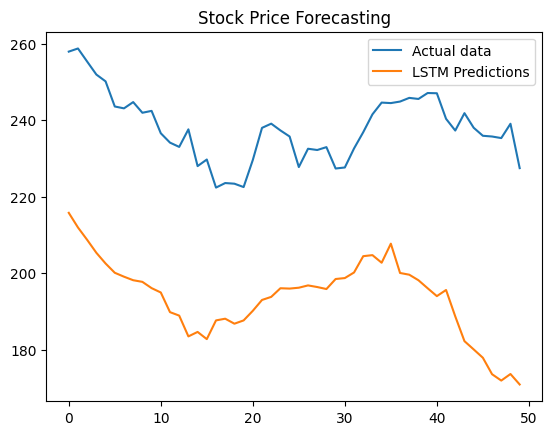

In [31]:
plt.plot(test_target, label='Actual data')
plt.plot(test_predict, label='LSTM Predictions')
plt.title('Stock Price Forecasting')
plt.legend()
plt.show()

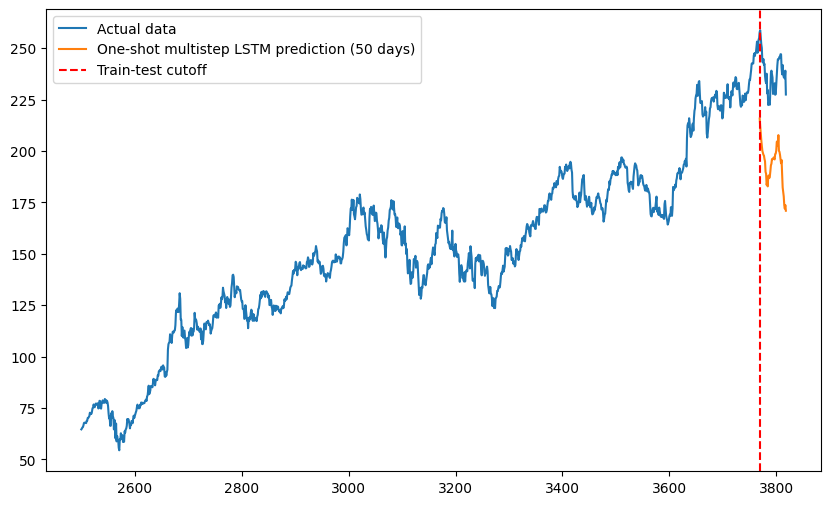

In [35]:
plt.figure(figsize=(10,6))
a = [x for x in range(2500, len(y))]
plt.plot(a, y[2500:], label='Actual data')
c = [x for x in range(len(y)-50, len(y))]
plt.plot(c, test_predict, label='One-shot multistep LSTM prediction (50 days)')
plt.axvline(x=len(y)-50, c='r', linestyle='--', label="Train-test cutoff")
plt.legend()
plt.savefig('lstm_final_plot.png', dpi=300)
plt.show()

For whatever reason, the model seems to be consistently off by ~40 dollars in predicting the price. I don't know where I have made a mistake, but I adjusted for this offset in the below plots, and the success of the model is evident in predicting directions.

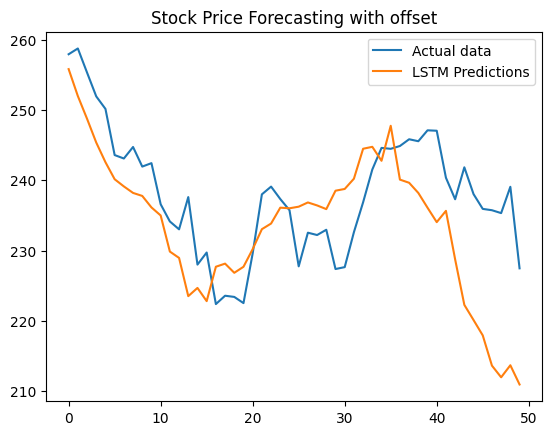

In [33]:
plt.plot(test_target, label='Actual data')
plt.plot([x+40 for x in test_predict], label='LSTM Predictions')
plt.title('Stock Price Forecasting with offset')
plt.legend()
plt.savefig('lstm_50_day_plot_with_offset.png', dpi=300)
plt.show()

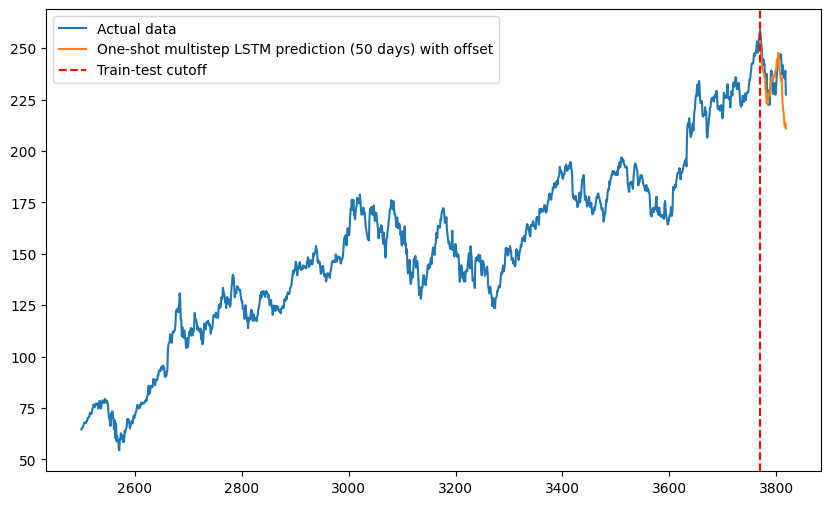

In [34]:
plt.figure(figsize=(10,6))
a = [x for x in range(2500, len(y))]
plt.plot(a, y[2500:], label='Actual data')
c = [x for x in range(len(y)-50, len(y))]
plt.plot(c, [x+40 for x in test_predict], label='One-shot multistep LSTM prediction (50 days) with offset')
plt.axvline(x=len(y)-50, c='r', linestyle='--', label="Train-test cutoff")
plt.legend()
plt.savefig('lstm_final_plot_with_offset.png', dpi=300)
plt.show()

# Conclusion
This model is by far the most complex in comparison to the other 3 made here. Though it is not perfect, as showcased by the mysterious offset in the predictions, it is surprisingly precise when it comes to predicting the timing and magnitude of trend changes in the given 50-day timeframe.

It is no wonder then, that LSTM-s are frequently used by real-life quant traders, together with other models based on Gradient Boosting, as well as Convolutional Neural Networks. Naturally stock prediction is a very specific usecase, which is reflected in how I didn't abide by certain best practices, such as the 80-20 train-test split, and instead opted for a very skewed 95-5 ratio. This, however, is not necessarily a bad practice, since stock markets are so high in randomness, that they are impossible to predict far into the future, and models require constant retraining. This retraining is also not a problem, since we have a steady flow of virtually infinite information on the markets.